### Imports

In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import eval7
from eval7 import Card, HandRange

# State & Action Abstraction

Because No-Limit texas holdem has $10^{71}$ decision nodes, it is infeasible to compute it in its unabstracted form. To solve this we have to create an abstraction of the game to reduce its size.  To do this we have two methods...

 - **State Abstraction** - Group similar hands together and compute strategies for the groups
 - **Action Abstraction** - Restrict bet sizes to common values e.g. (50% of pot, 100% of pot)

## State Abstraction

Many methods have been used to group strategically similar hands together.  The simplest is *Expected-Hand Strength* (EHS).  EHS is simply the odds of that hand to win versus a random hand.  To group hands together by EHS, we first calculate the EHS of every hand.  Then we use a clustering algorithm like K-means to group them together.

In [8]:
# get the EHS of AsAh
hand = [Card("As"), Card("Ah")]
all_hands = HandRange("22+,A2+,K2+,Q2+,J2+,T2+,92+,82+,72+,62+,52+,42+,32+")
ehs = eval7.py_hand_vs_range_monte_carlo(hand, all_hands, [], 10000)

print("EHS(AsAh) = ", ehs)

EHS(AsAh) =  0.8514999747276306


#### Problems with EHS

The main problem with EHS is that it would group hands that are strategically different together.  Here's an example

In [9]:
hand1 = [Card("Js"), Card("Ts")]
hand2 = [Card("4c"), Card("4d")]

ehs1 = eval7.py_hand_vs_range_monte_carlo(hand1, all_hands, [], 10000)
ehs2 = eval7.py_hand_vs_range_monte_carlo(hand2, all_hands, [], 10000)
print("EHS(JsTs) = ", ehs1)
print("EHS(4c4d) = ", ehs2)

EHS(JsTs) =  0.5691499710083008
EHS(4c4d) =  0.559149980545044


Notice how these hands have very similar EHS.  However, we would not want to group them together.  JTs suited is a *drawing-hand* and could likely improve to a straight or a flush or bust and be worth nothing.  44 is likely to remain a one-pair hand.  To highlight this difference, let's plot a histogram of EHS after showing all 5 cards for both hands.  

Text(0, 0.5, 'Count')

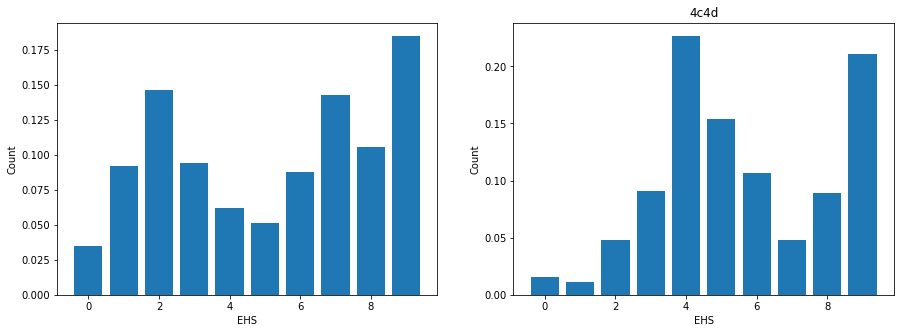

In [13]:
# First let's fix the flop
flop = [Card("9s"), Card("5d"), Card("Kc")]
def generate_histogram(hand, initial_board=[], n_samples=5000, n_bins=30):
    # where to store our histogram
    # lets take 1000 samples
    data = []
    for i in range(n_samples):
        # deal random turn and river
        deck = eval7.Deck()
        deck.shuffle()
        board = initial_board.copy()
        while len(board) < 5:
            new_card = deck.deal(1)
            if not new_card in board and not new_card in hand:
                board += new_card
        
        ehs = eval7.py_hand_vs_range_exact(hand, all_hands, board)
    
        data.append(ehs)

    return np.histogram(data, bins=n_bins)[0] / n_samples

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)


n_bins = 10

# plt.title("JsTs")
hist = generate_histogram([Card("Js"), Card("Ts")], initial_board=[], n_bins=n_bins)
plt.bar(range(n_bins), hist)
plt.xlabel("EHS")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.title("4c4d")
hist = generate_histogram([Card("4c"), Card("4d")], initial_board=[], n_bins=n_bins)
plt.bar(range(n_bins), hist)
plt.xlabel("EHS")
plt.ylabel("Count")

# plt.show()

The two graphs above show how the EHS for both hands change after the 5 public cards are revealed.

As we can we JsTs is either a weak or a strong hand once we reach the river, but almost never an average one.  On the other hand, 4c4d is usually an average hand and sometimes very strong (when it makes three-of-a-kind).  Because of this, we should not group these hands together.  Although their EHS is very similar, the probability distribution of their ehs could not be more different.

#### Earth Mover's Distance

Earth Mover's Distance (EMD) is a distance metric used to compare two distributions.  Given two histograms EMD returns the minimum cost of turning histogram A into histogram B.  A small EMD distance implies similarity between two histograms while a large distance means that the two distrubitions are not alike.  Although the above histograms have the same mean, their EMD is large because their distrubition of mass could not be more different.  This means that if we use EMD instead of EHS as our distance metric, JsTs will place into a different bucket than 4c4d which is what we want.

In [8]:
def wasserstein_distance(A,B):
    n = len(A)
    dist = np.zeros(n)
    for x in range(n-1):
        dist[x+1] = (A[x] + dist[x]) - B[x]
    return np.sum(abs(dist))

In [9]:
hist_JTs = generate_histogram([Card("Js"), Card("Ts")], n_samples=1000, n_bins=10)
hist_44 = generate_histogram([Card("4d"), Card("4c")], n_samples=1000, n_bins=10)
hist_KQs = generate_histogram([Card("Ks"), Card("Qs")], n_samples=1000, n_bins=10)

In [10]:
print("old EMD JsTs-4c4d: ", scipy.stats.wasserstein_distance(hist_JTs, hist_44))
print("old EMD JsTs-KsQs: ", scipy.stats.wasserstein_distance(hist_KQs, hist_JTs))

old EMD JsTs-4c4d:  0.027599999999999996
old EMD JsTs-KsQs:  0.023999999999999994


Notice that although the EHS of 4s4c and JsTs is more similar than the EHS of JsTs and KsQs, the EMD distance is smaller.  This is good because our strategy for JsTs should be more like our strategy KsQs since they are the same type of hand.

Earth Mover's distance has proven to be a very strong choice in the field of Poker AI and is still currently being used in combination with other techniques.  Today, the best known strategy for state-abstraction is to compute buckets at each betting round (PREFLOP, FLOP, TURN, and RIVER).  This allows us to use different techniques at each betting round.

For example, EMD distance would not work as a distance metric on the river because no more cards will be revealed so the hand has no chance to improve or get worse.  We could then use EHS, and this has shown to perform okay, but better yet we can use another special distance metric for the final round called **Opponent Cluster Hand Strength**

### Opponent Cluster Hand Strength

 - Here is the [Original Paper](#http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.295.2143&rep=rep1&type=pdf) on OCHS for more information

Opponent Cluster Hand Strength (OCHS) is a distance metric that requires two steps.

First, we compute an N bucket abstraction for the preflop betting round using EMD.  We commonly use somewhere between 6 and 12 buckets.  Each of these buckets represents a group of increasingly stronger hand-ranges.  Here are the strongest two buckets

 - AA,KK,QQ,JJ,TT,99,88
 - 66,77,A9o+,A8s+,KTo+,K7s+,QTs+,
 
Second, for each possible hand on the final round, we calculate how likely it is to beat each of the 8 buckets and store these results in a histogram as before.  We then use the $L_{2}$ distance as our distance metric between each of these histograms.  The $L_{2}$ distance metric is a simple pairwise distance function.  In our case it is the sum of the differences between each of the bins.

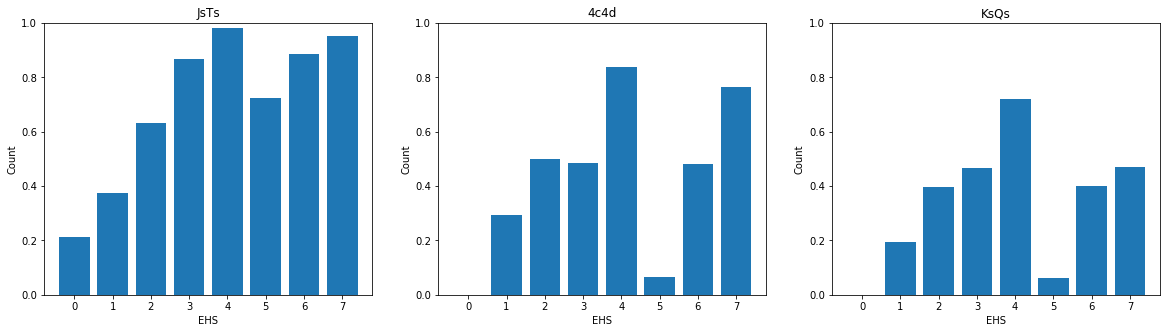

Board:  [Card("Ac"), Card("2d"), Card("Td"), Card("6c"), Card("9h")]
L2 dist JsTs-4c4d:  2.2090571150183678


In [11]:
opponent_clusters = [
    HandRange("88+"),
    HandRange("66,77,A9o+,A7s+,KTo+,K9s+,QTs+"),
    HandRange("33,44,55,A2s-A8s,K5s-K9s,A2o-A6o,K3o-K8o,QTo+"),
    HandRange("Q8o+,J8o+,T9s,Q7s-Q9s,J7s+,T7s+"),
    HandRange("22,K2o-K4o,Q2o-Q7o,J4o-J7o,J2s-J7s,Q2s-Q6s,K2s"),
    HandRange("T6o-T8o,96o-98o,86o,87o,76o,T3s-T7s,95s-98s,85s+,75s+,65s"),
    HandRange("J2o,J3o,T2o-T5o,92o-95o,84o,85o,75o,T2s,92s-94s,82s-84s,74s"),
    HandRange("82o-83o,72o-74o,62o-65o,52+,42+,32,62s-64s,72s,73s")
]

board = [Card("Ac"), Card("2d"), Card("Td"), Card("6c"), Card("9h")]

def generate_ochs_histogram(hand, board):
    data = np.zeros(len(opponent_clusters))
    data = [eval7.py_hand_vs_range_exact(hand, hr, board) for hr in opponent_clusters]
    return data

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)

plt.title("JsTs")
hist_1 = generate_ochs_histogram([Card("Js"), Card("Ts")], board)
plt.bar(x=range(len(opponent_clusters)), height=hist_1)
plt.xlabel("EHS")
plt.ylabel("Count")
plt.ylim([0,1])

plt.subplot(1, 3, 2)
plt.title("4c4d")
hist_2 = generate_ochs_histogram([Card("4c"), Card("4d")], board)
plt.bar(x=range(len(opponent_clusters)), height=hist_2)
plt.xlabel("EHS")
plt.ylabel("Count")
plt.ylim([0,1])

plt.subplot(1, 3, 3)
plt.title("KsQs")
hist_3 = generate_ochs_histogram([Card("Ks"), Card("Qs")], board)
plt.bar(x=range(len(opponent_clusters)), height=hist_3)
plt.xlabel("EHS")
plt.ylabel("Count")
plt.ylim([0,1])

plt.show()
print("Board: ", board)

# compute the l2 dist by summing the absolute difference of each bin
l2_dist = sum([abs(x-y) for x,y in zip(hist_1, hist_2)])
print("L2 dist JsTs-4c4d: ", l2_dist)

This shows us the expected probability of this each hand winning against each opponent cluster.  Notice how both hands do very poorly against the strongest clusters and very well against the weaker ones.  In this scenario 4c4d would be much closer to KsQs because both hands are relativly weak whereas JsTs has made second-top pair.

### Generating our own OCHS clusters using K-means with earth movers distance

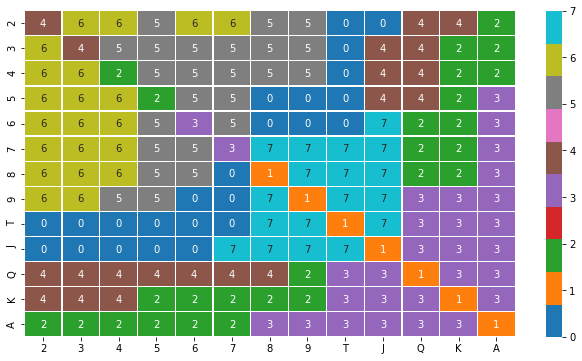

In [6]:
clusters = [
"8s7h,9s6h,9s7h,Ts2h,Ts3h,Ts4h,Ts5h,Ts6h,Ts7h,Js2h,Js3h,Js4h,Js5h,Js6h,5s8s,6s8s,5s9s,6s9s,2sTs,3sTs,4sTs,5sTs,6sTs,2sJs,",
"8s8h,9s9h,TsTh,JsJh,QsQh,KsKh,AsAh,",
"4s4h,5s5h,Qs9h,Ks5h,Ks6h,Ks7h,Ks8h,Ks9h,As2h,As3h,As4h,As5h,As6h,As7h,6sQs,7sQs,8sQs,3sKs,4sKs,5sKs,6sKs,7sKs,8sKs,2sAs,3sAs,4sAs,",
"6s6h,7s7h,QsTh,QsJh,KsTh,KsJh,KsQh,As8h,As9h,AsTh,AsJh,AsQh,AsKh,9sQs,TsQs,JsQs,9sKs,TsKs,JsKs,QsKs,5sAs,6sAs,7sAs,8sAs,9sAs,TsAs,JsAs,QsAs,KsAs,",
"2s2h,3s3h,Qs2h,Qs3h,Qs4h,Qs5h,Qs6h,Qs7h,Qs8h,Ks2h,Ks3h,Ks4h,3sJs,4sJs,5sJs,2sQs,3sQs,4sQs,5sQs,2sKs,",
"6s5h,7s5h,7s6h,8s5h,8s6h,9s4h,9s5h,3s4s,2s5s,3s5s,4s5s,3s6s,4s6s,5s6s,3s7s,4s7s,5s7s,6s7s,2s8s,3s8s,4s8s,2s9s,3s9s,4s9s,",
"2s3h,4s2h,4s3h,5s2h,5s3h,5s4h,6s2h,6s3h,6s4h,7s2h,7s3h,7s4h,8s2h,8s3h,8s4h,9s2h,9s3h,2s3s,2s4s,2s6s,2s7s,",
"9s8h,Ts8h,Ts9h,Js7h,Js8h,Js9h,JsTh,7s8s,7s9s,8s9s,7sTs,8sTs,9sTs,6sJs,7sJs,8sJs,9sJs,TsJs,",
]

ochs_matrix = np.zeros((13, 13))

def char_to_rank(c):
    if c == 'A': return 12
    if c == 'K': return 11
    if c == 'Q': return 10
    if c == 'J': return 9
    if c == 'T': return 8
    return int(c) - 2

for i in range(len(clusters)):
    cluster = clusters[i].split(',')
    for hand in cluster:
#         print(hand)
        if len(hand) != 4: continue
        rank1 = max(char_to_rank(hand[2]), char_to_rank(hand[0]))
        rank2 = min(char_to_rank(hand[2]), char_to_rank(hand[0]))
        if hand[1] == hand[3]:
            ochs_matrix[rank2][rank1] = i
        else:
            ochs_matrix[rank1][rank2] = i
            
labels = [str(x) for x in range(2, 10)] + ['T', 'J', 'Q', 'K', 'A']
plt.figure(figsize=(11, 6))
sns.heatmap(ochs_matrix, annot=True, xticklabels=labels, yticklabels=labels, cmap=sns.color_palette("tab10"), linewidths=.2)
plt.show()

### Potential Aware abstraction

Here a link to the [Original Paper](#https://www.aaai.org/ocs/index.php/AAAI/AAAI14/paper/viewFile/8459/8487) on potential-aware abstraction

Potential-Aware abstraction is an abstraction method that takes in to account the hands potential.  That is it calculates the probability that a hand on round $N$ will be placed into bucket $B$ in round $N+1$.  Potential-Aware abstractions are used to address the short-comings of the other distribution aware approachs.  While some hands can have similar EMD on the RIVER, their EHS distributions *throughout* other betting rounds can be much different.  Potential-Aware abstractions take these transitions into account and provide a much more robust abstraction.  To compute this abstraction we have to work backwards.

Say we have already computed an abstraction for the $TURN$ using $EMD$ and we want to compute a potential-aware abstraction for the $FLOP$.  To do this, we create a compute a histogram $H$ where $H_{i}$ is the percent chance that the next card will send our hand into bucket $i$ on the next round.

## Action Abstraction